In [1]:
import pandas as pd
import matplotlib.pyplot as plt

### 1. Чтение данных
Читаем данные, удаляем ненужные колонки

In [2]:
data = pd.read_csv('./data-001.csv',
                   parse_dates=['date_time'])
data = data.drop(
    columns=['oaid_hash', 'banner_id0', 'banner_id1', 'rate0', 'rate1', 'g0', 'g1', 'coeff_sum0', 'coeff_sum1'])
# TODO: data.sort_values(by='date_time')
data.head()

,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,impressions,clicks
0,2021-09-27 00:01:30,0,0,0,0,0,1,1
1,2021-09-26 22:54:49,1,1,0,0,1,1,1
2,2021-09-26 23:57:20,2,2,3,0,0,1,1
3,2021-09-27 00:04:30,3,3,0,1,1,1,1
4,2021-09-27 00:06:21,4,4,0,1,0,1,1


### 2. Анализ данных
Проанализируем данные: статистики по каждой фиче, количество уникальных значений, отсутствующих значений, гистограммы распределений значений каждой из фич.

In [3]:
import numpy as np

In [4]:
def analysis(data: pd.DataFrame):
    # множество статистических значений для датасета
    display(data.describe())

    # количество уникальных значений для каждой фичи
    print('Unique values count for each feature:')
    print(data.nunique(axis=0, dropna=True))
    print('-' * 60)

    # распределение значений каждой из фич
    for col in data.drop(columns=['date_time']).columns:
        data.hist(col, figsize=(15, 5), color='green')
        plt.show()

    # количество NaN значений в каждом столбце
    print('NaN values count for each feature:')
    print(data.isna().sum())
    print('-' * 60)

    # распределение количества сэмплов по дате и времени -- позволит увидеть, за какие моменты у нас в принципе есть данные, и в каком объеме
    print(f"Start day: {data['date_time'].min()}")
    print(f"End day: {data['date_time'].max()}")
    print("Date time samples count:")
    display(data.groupby('date_time').size())
    # TODO
    

Unique values count for each feature:
date_time          604712
zone_id              3444
banner_id            1633
campaign_clicks       822
os_id                  11
country_id             17
impressions             1
clicks                  2
dtype: int64
------------------------------------------------------------
NaN values count for each feature:
date_time          0
zone_id            0
banner_id          0
campaign_clicks    0
os_id              0
country_id         0
impressions        0
clicks             0
dtype: int64
------------------------------------------------------------
Start day: 2021-09-01 00:02:49
End day: 2021-10-02 23:59:59
Date time samples count:


,zone_id,banner_id,campaign_clicks,os_id,country_id,impressions,clicks
count,1.582147e+07,1.582147e+07,1.582147e+07,1.582147e+07,1.582147e+07,15821472.0,1.582147e+07
mean,8.152679e+01,3.816483e+02,6.238540e-01,1.840605e+00,4.346986e+00,1.0,2.668835e-02
std,1.632448e+02,3.959386e+02,9.249152e+00,1.530005e+00,4.317701e+00,0.0,1.611710e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00
25%,1.400000e+01,5.200000e+01,0.000000e+00,1.000000e+00,0.000000e+00,1.0,0.000000e+00
50%,1.900000e+01,2.170000e+02,0.000000e+00,2.000000e+00,4.000000e+00,1.0,0.000000e+00
75%,6.000000e+01,6.110000e+02,0.000000e+00,3.000000e+00,7.000000e+00,1.0,0.000000e+00
max,3.443000e+03,1.632000e+03,8.290000e+02,1.000000e+01,1.600000e+01,1.0,1.000000e+00


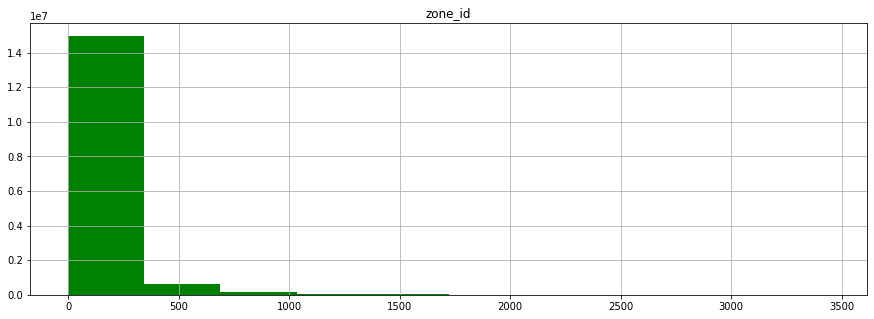

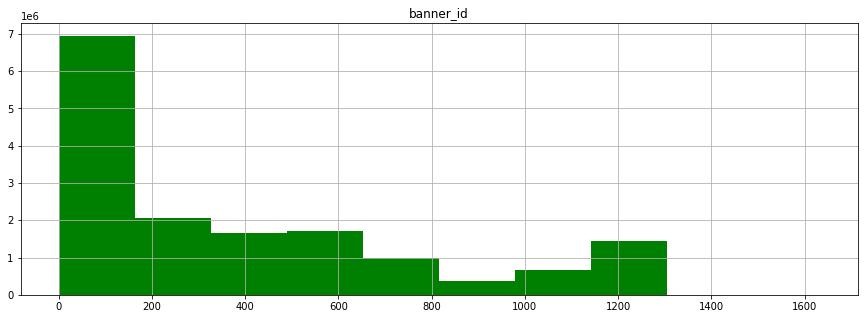

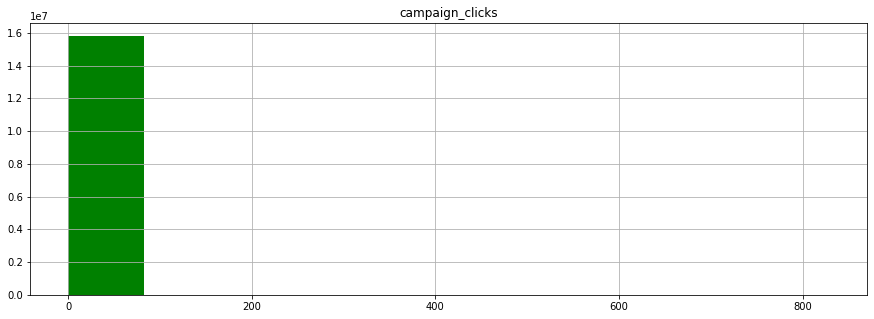

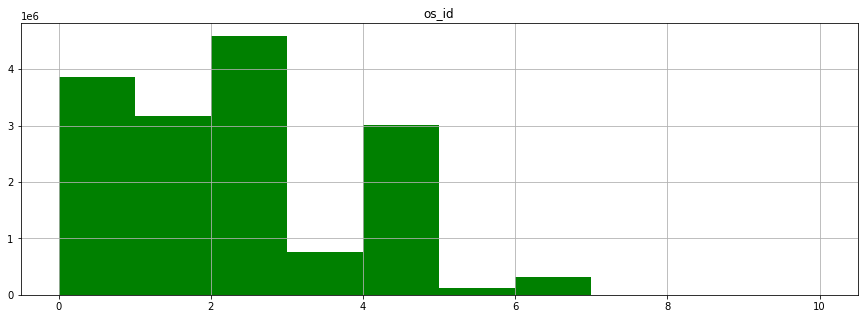

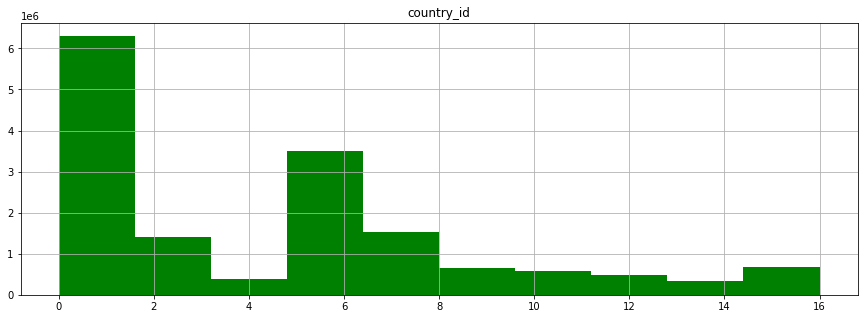

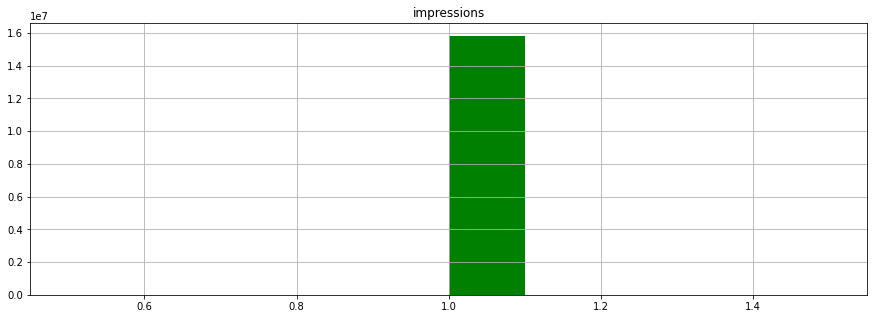

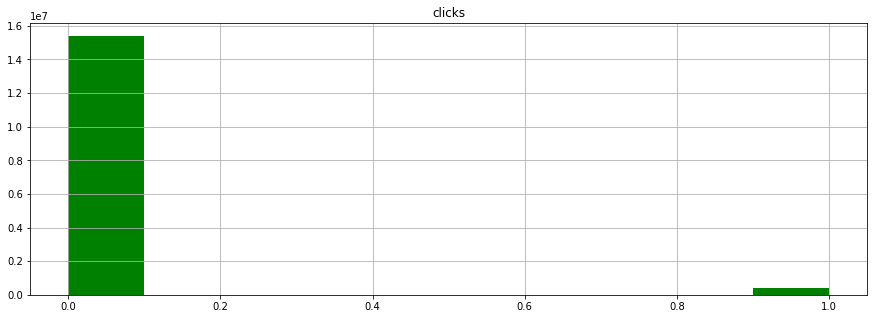

date_time
2021-09-01 00:02:49     1
2021-09-26 00:00:00    28
2021-09-26 00:00:01    28
2021-09-26 00:00:02    25
2021-09-26 00:00:03    30
                       ..
2021-10-02 23:59:55    22
2021-10-02 23:59:56    22
2021-10-02 23:59:57    19
2021-10-02 23:59:58    20
2021-10-02 23:59:59    19
Length: 604712, dtype: int64

In [5]:
analysis(data)

### 3. Фильтрация и конструирование фичей

Удалим повторяющиеся строки таблицы, если такие имеются

In [6]:
data = data.drop_duplicates()

Анализируя статистики, можем увидим, что значение поля impressions всегда одно и равно единице. Значит, все баннеры-сэмплы, данные о которых у нас имеются, в каждой конфигурации были показаны по одному разу. Так как фича является константой, она не играет роли при выборе класса объекта в нашей задаче классификации. Можем обойтись без этой колонки

In [7]:
data['impressions'].unique()

array([1])

In [8]:
data = data.drop(columns=['impressions'])
data.head()

,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,clicks
0,2021-09-27 00:01:30,0,0,0,0,0,1
1,2021-09-26 22:54:49,1,1,0,0,1,1
2,2021-09-26 23:57:20,2,2,3,0,0,1
3,2021-09-27 00:04:30,3,3,0,1,1,1
4,2021-09-27 00:06:21,4,4,0,1,0,1


Заметим, что все имеющиеся данные затрагивают только 2 месяца -- сентябрь и начало октября. Информация про год избыточна, тк у всех сэмплов одинакова. Кроме того, можем убрать измерения секунд, нам хватит знания часа и минут для каждого примера. Добавим отдельные столбцы day, hour, minute. После разделения на train и test впоследствии удалим столбец date_time. Добавим информацию про день недели как новую полезную для анализа рекламных событий фичу.

In [9]:
data['day'] = data['date_time'].dt.day
data['hour'] = data['date_time'].dt.hour
data['minutes'] = data['date_time'].dt.minute
data['weekday'] = data['date_time'].dt.day_name()

data.head()

,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,clicks,day,hour,minutes,weekday
0,2021-09-27 00:01:30,0,0,0,0,0,1,27,0,1,Monday
1,2021-09-26 22:54:49,1,1,0,0,1,1,26,22,54,Sunday
2,2021-09-26 23:57:20,2,2,3,0,0,1,26,23,57,Sunday
3,2021-09-27 00:04:30,3,3,0,1,1,1,27,0,4,Monday
4,2021-09-27 00:06:21,4,4,0,1,0,1,27,0,6,Monday


### 4. Train/ test splitting
Разделим данные на тренировочную и тестовую части. Тренировать модель будем на всех данных, полученных до последнего дня, тестировать -- на данных последнего дня, тк хотим научиться предсказывать на день вперед. 

In [10]:
# разделяющий день -- последний день, начиная с 00:00
splitting_datetime = data['date_time'].max()
splitting_datetime = splitting_datetime.replace(hour=0, minute=0, second=0, microsecond=0)
print(f'Splitting datetime: {splitting_datetime}')

train_data = data[data['date_time'] < splitting_datetime]
test_data = data[data['date_time'] >= splitting_datetime]

data = data.drop(columns=['date_time'])

print(f'Train samples: {len(train_data)}')
print(f'Test samples: {len(test_data)}')

Splitting datetime: 2021-10-02 00:00:00
Train samples: 13147256
Test samples: 2054177


### 5. Кодирование категориальных признаков
Чтобы перевести категориальные фичи в числовые значения, воспользуемся One-hot encoding'ом, сопоставив каждой категории вектор из 0 с 1 на одной из позиций. Категориальными у нас являются все фичи, кроме одной -- campaign_clicks (числовая). К числовой фиче для нормализации и стандартизации применим StandartScaler.

In [11]:
numerical_columns = ['campaign_clicks']

categorial_columns = list(data.columns.values)
categorial_columns.remove('campaign_clicks')

print('Categorial columns:')
print(categorial_columns)

Categorial columns:
['zone_id', 'banner_id', 'os_id', 'country_id', 'clicks', 'day', 'hour', 'minutes', 'weekday']


In [12]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# обработка категориальных фичей
oh_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=True)

train_data_cat = oh_encoder.fit_transform(train_data[categorial_columns])
test_data_cat = oh_encoder.transform(test_data[categorial_columns])

# обработка численных фичей
stand_scaler = StandardScaler()
train_data_num = stand_scaler.fit_transform(train_data[numerical_columns])
test_data_num = stand_scaler.transform(test_data[numerical_columns])

### 6. Train/ validate/ test X и y

Наконец, разделим train и test данные на признаки X и таргет y, а также выделим часть данных из train для валидации.

In [13]:
from sklearn.model_selection import train_test_split

def split_to_X_y(data: pd.DataFrame):
    X = data.drop(columns=['clicks'])
    y = data['clicks']
    return X, y


X_train, y_train = split_to_X_y(train_data)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15)
X_test, y_test = split_to_X_y(test_data)

### 7. Построение и обучение модели
В качестве модели выберем логистическую регрессию с 'liblinear' solver'ом

In [18]:
from sklearn.linear_model import LogisticRegression

In [14]:
def create_model(C=0.01):
    return LogisticRegression(max_iter=1000, solver='liblinear', C=C, verbose=2)

model = create_model()

Подберем оптимальный гиперпараметр C с помощью кросс-валидации:

In [ ]:
def cv():
    C_list = [1, 0.1, 0.01, 0.001]

Обучим модель

In [ ]:
model.fit(X_train, y_train)

### 8. Оценка качество обученной модели

In [19]:
from sklearn.metrics import roc_auc_score, log_loss

def calc_print_metrics(y_true, y_preds):
    print(f'Roc-auc baseline: {roc_auc_score(y_true, y_preds)}')
    print(f'Log-loss baseline: {log_loss(y_true, y_preds)}')

In [ ]:
model_preds = model.predict_proba(X_test)[:, 1]
calc_print_metrics(y_test, model_preds)

### 9. Сравнение с бейзлайном
В качестве бейзлайна возьмем модель, всегда выдающую среднее значение таргета на train'е. Посчитаем log-loss и roc-auc и сравним полученными значениями метрик у нашей модели логистической регресии.

In [20]:
baseline_mean_prediction = y_train.mean()
baseline_preds = [baseline_mean_prediction] * len(y_test)

calc_print_metrics(y_test, baseline_preds)

Roc-auc baseline: 0.5
Log-loss baseline: 0.1571386178512465


Roc auc бейзлайн модели ниже нашей логистической модели, а log loss выше. Значит, у нас получилось обучить модель, побивающую бейзлайн.